In [48]:
from read_mem import *
import matplotlib.pyplot as plt
import pathlib

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[1. 2. 3. 4.]


UnboundLocalError: local variable 'outfoldername' referenced before assignment

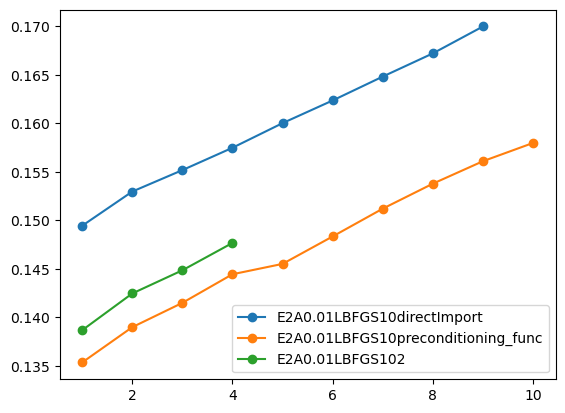

In [54]:
# filenames = ["/home/bastian/D1/registration/mrislurm/436844_log_python_srun.txt"]

path = pathlib.Path("/home/bastian/D1/registration/cubeslurm/")

# slurmids = [437139, 437140]

# slurmids += [437147, 437148]

slurmids = [437150]

slurmids += [437152, 437153]

slurmids += [437156, 437157]


path = pathlib.Path("/home/bastian/D1/registration/cubeslurm/")

slurmids = [437307, 437328, 437335, 437339]

filenames = [path / (str(slurmid) + "_log_python_srun.txt") for slurmid in slurmids]

# filenames = ["/home/bastian/D1/registration/mrislurm/436856_log_python_srun.txt",
# "/home/bastian/D1/registration/mrislurm/436844_log_python_srun.txt"
# ]

minm, maxm = 1e16, 0
for filename in filenames:

    

    mema, outfoldername = read_memory(filename)

    outfoldername = outfoldername.replace("\n", "")
    outfoldername = outfoldername.replace(" ", "")
    
    
    try:
        print(mema[:, 0])
    except IndexError:
        print(outfoldername, "probably still running init? Continue.")
        continue
    # minm = min([np.min(mema[:, 1]), minm])

    marker = "o"
    linestyle = "-"

    if "self" in outfoldername:
        marker = "d"

    if "NOSMOOTHEN" in outfoldername:
        marker = "x"
    if "nocopy" in outfoldername:
        linestyle = "--"

    minm = None

    plt.plot(mema[:,0], mema[:,1] / (1 + 0 * mema[0,1]), marker=marker, linestyle=linestyle, label=outfoldername)
    plt.legend()

plt.xlabel("lbfgs iteration")
plt.ylabel("Increase in memory after first iteration")
plt.xlim(1, None)
plt.ylim(minm, None)
plt.show()